## TO does:
- include segment variables as ranking variable
- hour
- handle the problem of skewed data (remove +, dupicate -, or other) - stratified CV
- which evaluation metric is crucial (business)
- add sin and cos to pipelines (own pipelines?)
- add booking date DOW etc.
- remove outliers
- set trip_duration for one way to 999?

## TO Asks:
- what does the ancillaries price depend on? (route + season)
- are we filtering only luggage prices here?
- we start with model only for Basic family fare?
- is APO model in use? for which routes/dates?

In [1]:
# -*- coding: utf-8 -*-
"""
One hot encoding using pandas for multiple columns within the data frame. 
Converts categorical variable into dummy/indicator variables, categorical 
columns are afterward removed.
	Input:
		@data - pandas d.f. with data
		@ohe_variables - list with variables' names (strings) to be converted
		@verbose - should print logger messages on the screen and save them to .log file?
		@logger - logger connection
	Returns:
		@data - pandas d.f. with data, with ohe input columns delated and ohe output columns inlcuded
		@ohe_columns_out_names - list with strings with ohe column names after ohe conversion
"""
import pandas as pd
def data_ohe(data,
			 ohe_variables,
			 verbose,
			 logger):
    try:
        if verbose:
            logger.info('One hot encoding starts, function data_ohe(), variables: ')
        ohe_columns_out_names = list()
        for i in ohe_variables:
            #if data[i].value_counts() is not unique --introduce
            if verbose:
                logger.info(i)
            if i in data.columns:
                dummies = pd.get_dummies(data[i], drop_first = True, prefix = i)
                data = pd.concat([data, dummies], axis=1)
                data = data.drop([i], axis=1)
                ohe_columns_out_names = ohe_columns_out_names + list(dummies.columns)

        if verbose:
            logger.info('One hot encoding end')
    except Exception:
        if verbose:
            logger.exception("Fatal error in data_ohe()")
        raise
    return data, ohe_columns_out_names

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    #plt.ylim([0, 1])
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

In [2]:
import numpy as np
import category_encoders as ce
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, accuracy_score
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from functools import reduce
#from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import OneHotEncoderEstimator, OneHotEncoderModel, OneHotEncoder, StringIndexer, VectorAssembler, RFormula
from pyspark.ml.regression import RandomForestRegressor as RFRegr, RandomForestRegressionModel
from pyspark.sql.types import *
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import lit, when, col, month, dayofweek, sin,cos
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
spark = SparkSession\
        .builder\
        .appName("proceso-mediana")\
        .config("spark.dynamicAllocation.enabled", 'true')\
        .config("spark.dynamicAllocation.maxExecutors", '8')\
        .config("spark.dynamicAllocation.minExecutors", '1')\
        .config("spark.dynamicAllocation.initialExecutors", '1')\
        .config('spark.executor.cores', '8')\
        .config('spark.cores.max', '12')\
        .config("spark.executor.memory", '6g')\
        .config("spark.driver.memory", '15g')\
        .config("spark.driver.maxResultSize", '7g')\
        .config("spark.sql.crossJoin.enabled", "true")\
        .config("spark.shuffle.service.enabled", "true")\
        .config("spark.sql.parquet.writeLegacyFormat", "true")\
        .config("spark.executor.memoryOverhead", "2g")\
        .enableHiveSupport()\
        .getOrCreate()
sqlContext = SQLContext(spark)  

In [128]:
"""
bagsSchema = StructType([
  StructField('flight_sk', IntegerType() , True) \
 ,StructField('rec_id', StringType() , True) \
 ,StructField('route', StringType() , True) \
 ,StructField('flight_date', DateType() , True) \
 ,StructField('booking_date', DateType() , True) \
 ,StructField('seats', IntegerType() , True) \
 ,StructField('km', IntegerType() , True) \
 ,StructField('family_fare', StringType() , True) \
 ,StructField('passengers', IntegerType() , True) \
 ,StructField('antel_compra', IntegerType() , True) \
 ,StructField('trip_duration', IntegerType() , True) \
 ,StructField('weekend_trip', IntegerType() , True) \
 ,StructField('family_trip', IntegerType() , True) \
 ,StructField('couple_trip', IntegerType() , True) \
 ,StructField('cluster_micro', IntegerType() , True) \
 ,StructField('cluster_macro', IntegerType() , True) \
 ,StructField('cluster', StringType() , True) \
 ,StructField('festivity', IntegerType() , True) \
 ,StructField('price_comp', DoubleType() , True) \
 ,StructField('class_type', StringType() , True) \
 ,StructField('season', StringType() , True) \
 ,StructField('RT_OW', StringType() , True) \
 ,StructField('price_anc', StringType() , True) \
 ,StructField('ticket_amount', DoubleType() , True) \
 ,StructField('sales_qty', IntegerType() , True) \
 ,StructField('NNN', DoubleType() , True)
 ])
 #.schema(bagsSchema)\
 """

"\nbagsSchema = StructType([\n  StructField('flight_sk', IntegerType() , True)  ,StructField('rec_id', StringType() , True)  ,StructField('route', StringType() , True)  ,StructField('flight_date', DateType() , True)  ,StructField('booking_date', DateType() , True)  ,StructField('seats', IntegerType() , True)  ,StructField('km', IntegerType() , True)  ,StructField('family_fare', StringType() , True)  ,StructField('passengers', IntegerType() , True)  ,StructField('antel_compra', IntegerType() , True)  ,StructField('trip_duration', IntegerType() , True)  ,StructField('weekend_trip', IntegerType() , True)  ,StructField('family_trip', IntegerType() , True)  ,StructField('couple_trip', IntegerType() , True)  ,StructField('cluster_micro', IntegerType() , True)  ,StructField('cluster_macro', IntegerType() , True)  ,StructField('cluster', StringType() , True)  ,StructField('festivity', IntegerType() , True)  ,StructField('price_comp', DoubleType() , True)  ,StructField('class_type', StringType(

### Read old data from Moha

In [ ]:
"""
#old data from file from Moha (saved in S3)
s3_input_data_load_path = 's3://vueling-data-lake/3-analytics/datasets/ds-classification-bag/df_res'
bags_booking_data = spark\
.read\
.format('csv')\
.option("header", "false")\
.option("delimiter",";")\
.load(s3_input_data_load_path)

oldColumns = ['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8',
              '_c9', '_c10', '_c11', '_c12', '_c13', '_c14', '_c15', '_c16',
              '_c17', '_c18', '_c19', '_c20', '_c21', '_c22', '_c23', '_c24', '_c25']
newColumns = ["flight_sk", "rec_id", "route", "dt_flight", "dt_booking", "seats", "km", "family_fare", 
              "passengers", "antel_compra", "trip_duration", "weekend_trip", "family_trip", "couple_trip", "cluster_macro", "cluster_micro",
              "cluster", "festivity", "price_comp", "class", "season", "RT_OW", 
              "price_anc", "price_ticket", "sales_qty", "NNN"]
bags_booking_data = reduce(lambda bags_booking_data,
                idx: bags_booking_data.withColumnRenamed(oldColumns[idx],
                                              newColumns[idx]),
                range(len(oldColumns)),
                bags_booking_data)
"""

### Load actual data (01.04.18-01.04.19)

In [3]:
sample_bags = 0.1

bags_booking_data = spark.read.format('parquet')\
.load('s3://vueling-data-lake/3-analytics/datasets/ds-classification-bag/new_bag_classif_data.parquet')\
.sample(sample_bags)

In [4]:
bags_booking_data = bags_booking_data.withColumnRenamed('passangers', 'passengers')


cols_integer = ["flight_sk", "seats", "km", "passengers", "antel_compra", "trip_duration", "weekend_trip", "family_trip", "couple_trip", "sales_qty", "festivity"]
cols_date = [ "dt_flight", "dt_booking"]
cols_double = ["price_comp", "price_anc", "price_ticket"]

bags_booking_data = bags_booking_data.fillna({'price_comp': 0.001})
for i in cols_integer:
    bags_booking_data = bags_booking_data.withColumn(i, bags_booking_data[i].cast(IntegerType()))
    bags_booking_data = bags_booking_data.fillna({i: 0})
for i in cols_date:
    bags_booking_data = bags_booking_data.withColumn(i, bags_booking_data[i].cast(DateType()))
for i in cols_double:
    bags_booking_data = bags_booking_data.withColumn(i, bags_booking_data[i].cast(DoubleType()))
    bags_booking_data = bags_booking_data.fillna({i: 0})
bags_booking_data = bags_booking_data.fillna({'RT_OW': 0})
#bags_booking_data = bags_booking_data.fillna({'class': 0})
bags_booking_data = bags_booking_data.fillna({'sales_qty': 0})
bags_booking_data = bags_booking_data.fillna({'cluster_macro': 0})
bags_booking_data = bags_booking_data.fillna({'cluster_micro': 0})
bags_booking_data = bags_booking_data.withColumn("dt_flight_month",  month(col("dt_flight")))
bags_booking_data = bags_booking_data.withColumn("dt_flight_dow",  dayofweek(col("dt_flight")))
bags_booking_data = bags_booking_data.withColumn("dt_booking_month",  month(col("dt_booking")))
bags_booking_data = bags_booking_data.withColumn("dt_booking_dow",  dayofweek(col("dt_booking")))
#bags_booking_data.describe().toPandas().transpose()


### Choose variables:

In [5]:
col_target = 'id_bag'
cols_numerical = ["seats", "km", "passengers", "antel_compra", "trip_duration", "weekend_trip", "family_trip", "couple_trip", 
                 "festivity", 'price_anc', 'price_comp', 'price_ticket', 'id_competitors', 'price_vs_competitors', 'price_vs_ticket', 'id_one_way'] #, route, hour
cols_numerical = ["km", "passengers", "antel_compra", "trip_duration", "weekend_trip", "family_trip", "couple_trip", 
                 "festivity", 'price_anc', 'price_comp', 'price_ticket', 'id_competitors']
cols_cyclical_in = ['dt_flight_month', 'dt_booking_month']
cols_categorical = ["season", "RT_OW", "cluster_micro", "cluster_macro", "dt_flight_dow", "dt_booking_dow", "seats"] #class
#cols_categorical = ["season", "RT_OW", "cluster_macro", "dt_flight_dow", "family_fare"]
#cols_ohe_out = [s + '_catVec' for s in cols_ohe_in]
cols_variables_sin = [s + '_sin' for s in cols_cyclical_in]
cols_variables_cos = [s + '_cos' for s in cols_cyclical_in]
cols_cyclical_out = cols_variables_sin+cols_variables_cos
cols_numerical = cols_numerical+cols_cyclical_out

In [6]:
#only class Basic for starters
bags_booking_data = bags_booking_data.filter(col('family_fare')=='Basic')
bags_booking_data = bags_booking_data.withColumn('id_bag', when((bags_booking_data.sales_qty > 0), 1).otherwise(0))

bags_booking_data = bags_booking_data.withColumn('id_competitors', when((bags_booking_data.price_comp > 0), 1).otherwise(0))
bags_booking_data = bags_booking_data.withColumn('price_vs_competitors', bags_booking_data.price_anc/bags_booking_data.price_comp)
bags_booking_data = bags_booking_data.withColumn('price_vs_ticket', bags_booking_data.price_anc/bags_booking_data.price_ticket)
bags_booking_data = bags_booking_data.withColumn('id_one_way', when((bags_booking_data.trip_duration == 0), 1).otherwise(0))

for i in range(len(cols_cyclical_in)):
    distinct_values_count = bags_booking_data.select(cols_cyclical_in[i]).distinct().count()
    bags_booking_data = bags_booking_data.withColumn(cols_cyclical_in[i]+'_sin', sin(2*np.pi*col(cols_cyclical_in[i]).cast(DoubleType())/distinct_values_count))
    bags_booking_data = bags_booking_data.withColumn(cols_cyclical_in[i]+'_cos', cos(2*np.pi*col(cols_cyclical_in[i]).cast(DoubleType())/distinct_values_count))
bags_booking_data.cache()

bags_booking_data_pnd = bags_booking_data.toPandas()
#just in case
bags_booking_data_pnd.sales_qty.fillna(0, inplace=True)
bags_booking_data_pnd = bags_booking_data_pnd.drop(['price_unit', 'date_anc'], axis=1)
bags_booking_data_pnd = bags_booking_data_pnd.dropna(how='any')
#print(bags_booking_data_pnd.isna().sum() )



### Remove outliers:

In [10]:
#for OW ticket, put trip_duration -999
bags_booking_data_pnd.loc[bags_booking_data_pnd.RT_OW=='OW','trip_duration'] = -999
#remove outliers
bags_booking_data_pnd = bags_booking_data_pnd[bags_booking_data_pnd.passengers < 20] #92 with value > 20, max 56
bags_booking_data_pnd = bags_booking_data_pnd[bags_booking_data_pnd.antel_compra < 365]# 1 with value -1, 43 with value>365
#bags_booking_data = bags_booking_data[bags_booking_data.price_comp < 300] #618 with value>300, 22-342 euros
bags_booking_data_pnd = bags_booking_data_pnd[bags_booking_data_pnd.price_ticket < 300] #from -10000 to 260000, obviously wrong (nr opf pax included during check)
bags_booking_data_pnd = bags_booking_data_pnd[bags_booking_data_pnd.price_ticket > 10]
bags_booking_data_pnd = bags_booking_data_pnd[bags_booking_data_pnd.trip_duration < 90] #500 with values over 90, 0 for OW
bags_booking_data_pnd = bags_booking_data_pnd[bags_booking_data_pnd.sales_qty < 10] #max is 45, only 53 over 10, equal to pax number
bags_booking_data_pnd = bags_booking_data_pnd[bags_booking_data_pnd.km < 4000] #2 over 4000, max 6800

### One Hot Encoding

In [ ]:
bags_booking_data_pnd.to_csv

In [9]:
#ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True, cols=cols_categorical)
pipeline_ohe = Pipeline([('enkodowanie', ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True, cols=cols_categorical))])
pipeline_ohe = pipeline_ohe.fit(bags_booking_data_pnd)
data_ohe = pipeline_ohe.transform(bags_booking_data_pnd)

cols_ohe_out = list(set(list(data_ohe.columns)) - set(list(bags_booking_data_pnd.columns)))
cols_features_full = cols_numerical+cols_ohe_out
data = data_ohe.loc[:,cols_features_full+[col_target]]

### Data Split

In [10]:
# create training and testing vars
X = data[cols_features_full]
y = data[col_target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1042542, 73) (1042542,)
(260636, 73) (260636,)


### Model fit

In [14]:
#from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=5,
                    learning_rate=0.1,
                    n_estimators=200,
                    colsample_bytree=0.8,
                    subsample=0.8,
                    #silent=True,
                    #objective='binary:logistic',
                    #booster='gbtree',
                    n_jobs=8)
pipeline_xgb = Pipeline([('klasyfikowanie', xgb)])
pipeline_xgb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('klasyfikowanie', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8))])

### Apply pipelines to new data
Need to make sin + cos as well later

In [41]:
#take one pax data (this will be delivered from web API as .json or whatever)
data_new = bags_booking_data_pnd#pd.DataFrame(bags_booking_data_pnd.iloc[0:2,:])#
data_new = data_new.drop('price_anc', axis=1)
data_new['index_pax'] = data_new.index

In [ ]:
#data_new_all_prices['price_vs_competitors'] = data_new_all_prices['price_anc']/data_new_all_prices['ticket_amount']
#data_new_all_prices['price_vs_ticket'] = data_new_all_prices['price_anc']/data_new_all_prices['price_comp']

In [ ]:
#add all possible prices as new column for given pax data
price_min = 10
price_max = 30
price_list = pd.DataFrame(pd.Series(range(price_min,price_max+1)))
price_list.rename(columns={0:'price_anc'}, 
                 inplace=True)
price_list['key'] = 0
data_new.loc[:,'key'] = 0
data_new_all_prices = data_new.merge(price_list, how='left', on = 'key')
data_new_all_prices.drop('key',1, inplace=True)

#apply pipelines to new data
data_new_all_prices_ohe = pipeline_ohe.transform(data_new_all_prices.drop('index_pax', axis=1))
data_new_all_prices_ohe = data_new_all_prices_ohe[cols_features_full]
predict_xgb = pipeline_xgb.predict(data_new_all_prices_ohe)
predict_probabilities = pipeline_xgb.predict_proba(data_new_all_prices_ohe)
#add predicted columns
data_new_all_prices['buy_proba'] = predict_probabilities[:,1]
data_new_all_prices['id_buy'] = predict_xgb

In [74]:
check_flex = data_new_all_prices.groupby('index_pax').agg({'buy_proba': [pd.np.min, pd.np.max]}).reset_index()
print('Mean buy probablity between 10 and 30 euros from all pax: '+str(np.mean(check_flex.buy_proba.amin-check_flex.buy_proba.amax)))
#check_flex[(abs(check_flex.buy_proba.amin-check_flex.buy_proba.amax)>0.1)].head()

Mean buy probablity between 10 and 30 euros from all pax: -0.025035905


Text(0, 0.5, 'Probability (%)')

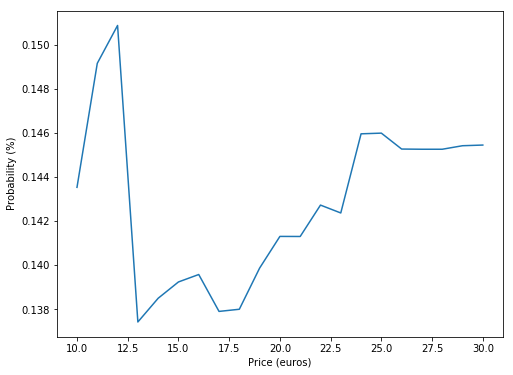

In [75]:
price_vs_proba = data_new_all_prices.groupby('price_anc')['buy_proba'].mean().reset_index()
plt.figure(figsize=(16, 12))
plt.plot(price_vs_proba.price_anc, price_vs_proba.buy_proba)
plt.xlabel('Price (euros)')
plt.ylabel('Probability (%)')

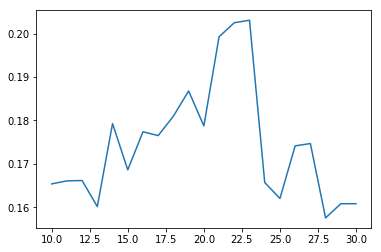

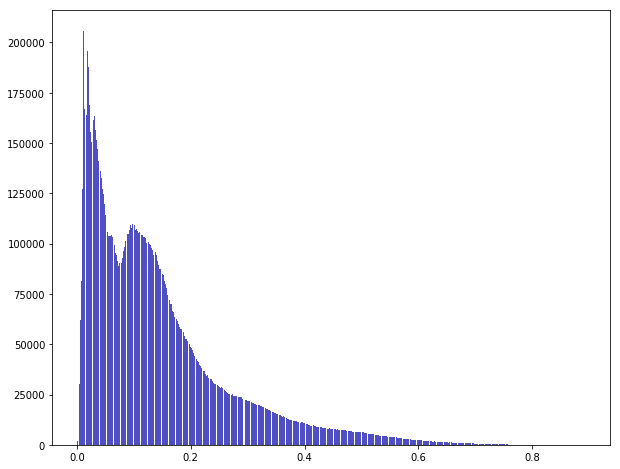

In [76]:
plt.figure(figsize=(10, 8))
n, bins, patches = plt.hist(x=predict_probabilities[:,1],
                            bins='auto',
                            color='#0504aa',
                            alpha=0.7,
                            rwidth=0.85)

In [265]:
df_total["pred_lin_regr"] = clf.predict(Xtest) 


y_pred_i[col_predict] = y_hats
data_list[model].loc[y_pred_i.index, col_predict] = y_pred_i[col_predict]

array([[0.95412165, 0.04587834],
       [0.95412165, 0.04587834],
       [0.95412165, 0.04587834],
       ...,
       [0.81473166, 0.18526833],
       [0.81473166, 0.18526833],
       [0.81473166, 0.18526833]], dtype=float32)

## Model CV

In [11]:
#from xgboost import XGBClassifier
xgb = XGBClassifier(n_jobs=8)
param_grid_xgb = {
              'n_estimators': [100,200],
              'max_depth': [3,5,7],
              'colsample_bytree ': [0.7,0.8],
              'subsample ': [0,7,0.8],
              'learning_rate': [0.1,0.05,0.01]
              }
param_grid_xgb = {
              'n_estimators': [200],
              'max_depth': [5],
              'colsample_bytree ': [0.8],
              'subsample ': [0.8],
              'learning_rate': [0.1]
              }
grid_xgb = GridSearchCV(estimator=xgb,
                        param_grid=param_grid_xgb,
                        scoring='roc_auc',
                        cv=10)
grid_xgb.fit(X_train, y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200], 'max_depth': [5], 'colsample_bytree ': [0.8], 'subsample ': [0.8], 'learning_rate': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

from sklearn.ensemble import RandomForestClassifier

param_grid = {
              'n_estimators': [100,200], #100
              'max_depth': [9,12,15],    #15
              'min_samples_leaf': [5, 10, 15], #5
               'max_features': [0.8,1.0]       #1.0
              }

clf = RandomForestClassifier(n_jobs=8)
grid_clf = GridSearchCV(estimator=clf,
                        param_grid=param_grid,
                        scoring='roc_auc',
                        cv=10)
grid_clf.fit(X_train, y_train)




### XGBoost model evalution metrics

best_estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, colsample_bytree =0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=8,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, subsample =0.8)
best_params_: {'colsample_bytree ': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample ': 0.8}
best_score_: 0.7728617908304536
confusion_matrix: [[159830  64384]
 [ 11747  24675]]
precision_score: 0.2770635196891948
recall_score: 0.6774751523804294
f1_score: 0.39328663303607714
ROC AUC: 0.7717270850706177


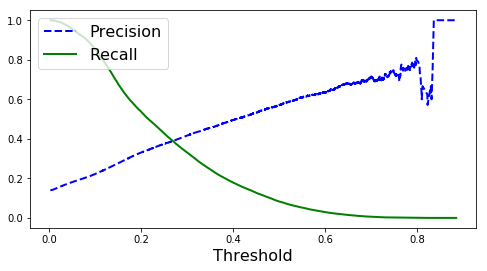

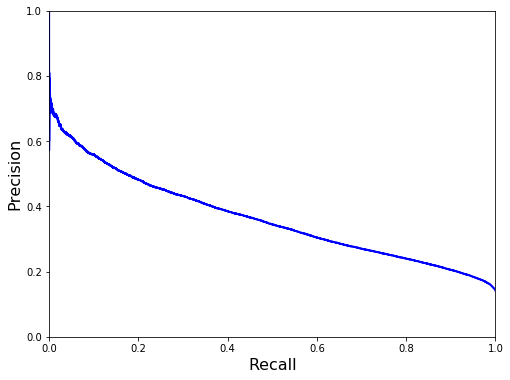

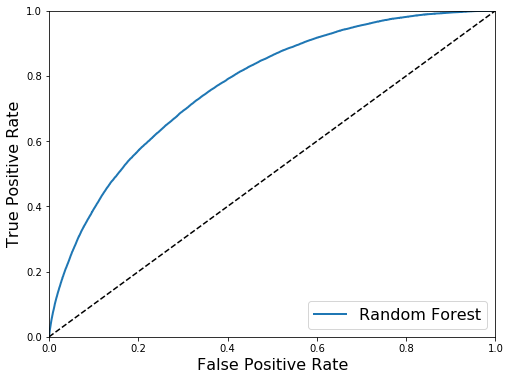

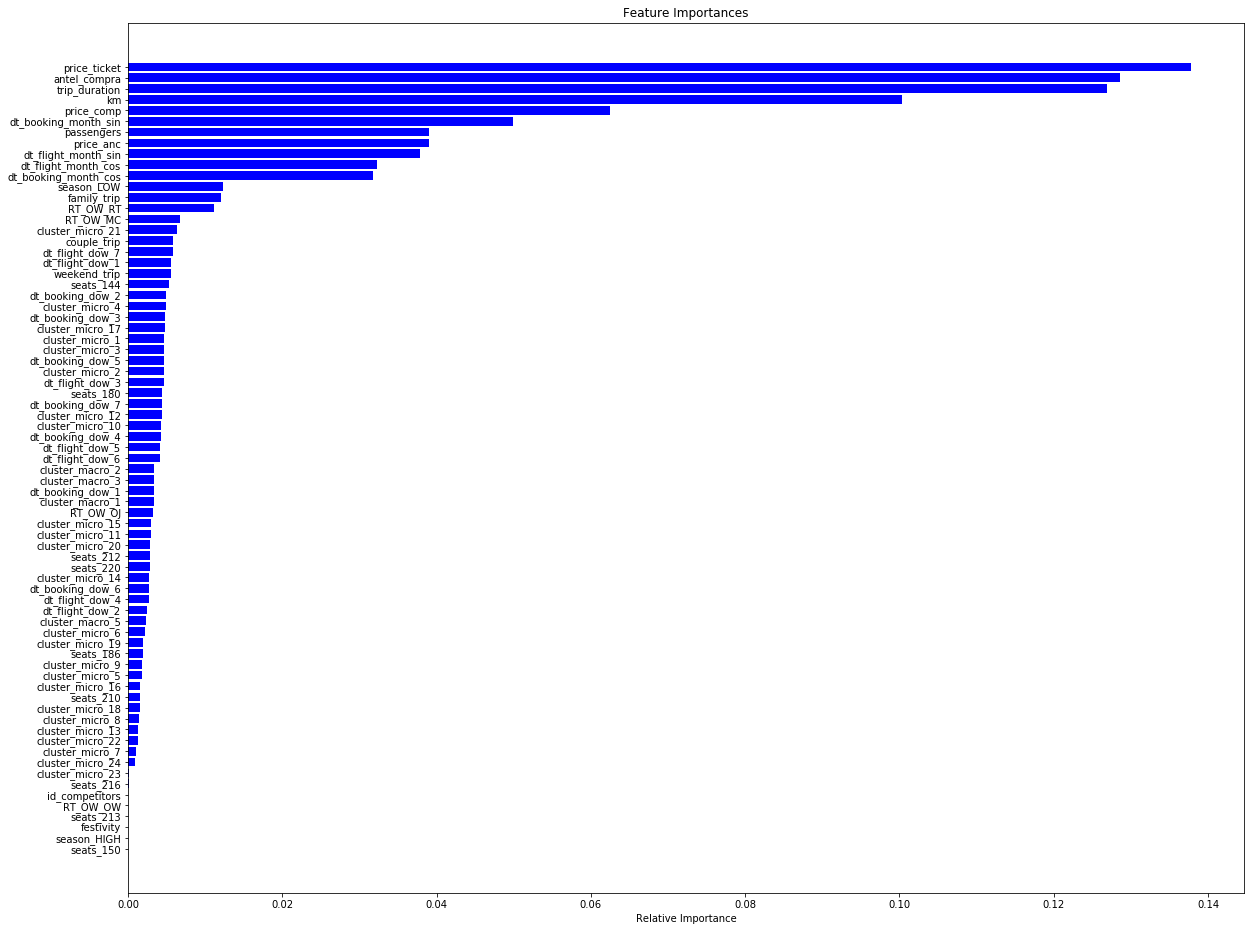

In [12]:
threshold = 0.15

y_test_pred = grid_xgb.predict(X_test)
#y_probas_xgb = cross_val_predict(grid_xgb.best_estimator_, X_test, y_test, cv=10,
#                                    method="predict_proba")
y_probas_xgb = grid_xgb.predict_proba(X_test)
y_test_pred = np.where(y_probas_xgb[:, 1] > threshold, 1, 0)


y_scores_xgb = y_probas_xgb[:, 1] # score = proba of positive class
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_xgb)

print('best_estimator: '+str(grid_xgb.best_estimator_))
print('best_params_: '+str(grid_xgb.best_params_))
print('best_score_: '+str(grid_xgb.best_score_))
print('confusion_matrix: '+str(confusion_matrix(y_test, y_test_pred)))
print('precision_score: '+str(precision_score(y_test, y_test_pred)))
print('recall_score: '+str(recall_score(y_test, y_test_pred)))
print('f1_score: '+str(f1_score(y_test, y_test_pred)))
print('ROC AUC: '+str(roc_auc_score(y_test, y_scores_xgb)))

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_scores_xgb)

plt.figure(figsize=(8, 6))
#plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_xgb, tpr_xgb, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()


features = cols_features_full
importances = grid_xgb.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 16))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Here continues as mllib code

In [7]:
#R version of OHE+strin_indexer+vectorAssembler
cols_features_r = cols_features + ["RT_OW"] # cols_ohe_in
r_formula_bags = col_target+' ~ ' + ' + '.join(cols_features_r)
bagsRPipeline = RFormula(formula=r_formula_bags,
                         featuresCol="featuresR",
                         labelCol="labelR")
bagsBookingDataR = bagsRPipeline.fit(bags_booking_data).transform(bags_booking_data)

In [ ]:
# Split data into training (60%) and test (40%)
training, test = data.randomSplit([0.6, 0.4], seed=11)

In [16]:
#indexer: transforms string values into numeric values, the value that occurs in data most is indexed as zero, second as 1 etc.
indexers = [StringIndexer(inputCol=x,
                          outputCol=x+'_tmp',
                          handleInvalid='keep')
            for x in cols_ohe_in]
#one hot encoding
cols_ohe_in_tmp = [i + '_tmp' for i in cols_ohe_in]
encoder = OneHotEncoderEstimator(dropLast=True,
                                 inputCols=cols_ohe_in_tmp,
                                 outputCols=cols_ohe_out,
                                 handleInvalid ='keep')
#add to pipeline
pipelineTmp = indexers + [encoder]
assembler = VectorAssembler(inputCols=cols_features_full, outputCol='features')
pipelineTmp = pipelineTmp + [assembler]
pipelineDataPrep = Pipeline(stages=pipelineTmp)
pipelineDataPrepFit = pipelineDataPrep.fit(bags_booking_data)
bagsBookingData = pipelineDataPrepFit.transform(bags_booking_data)

In [74]:
#only two metrics available for binary calssification CV in MLLib: metricName='areaUnderROC'|'areaUnderPR'

#this only specifies estimator to be crossvalidated
RFModel = RandomForestClassifier(labelCol=col_target, featuresCol='features') 
evaluator = BinaryClassificationEvaluator(labelCol=col_target, metricName='areaUnderROC') #areaUnderPR
numFolds = 10
#this only says our evaluator is RFModel 
pipeline = Pipeline(stages=[RFModel])
#this only defines the param grid
paramGrid = (ParamGridBuilder()
             .addGrid(RFModel.numTrees, [50, 100])
             .addGrid(RFModel.maxDepth, [3, 10])
             .addGrid(RFModel.subsamplingRate, [0.8, 1.0])
             .build())
#.addGrid(RFModel.featureSubsetStrategy, [0.5, 0.8])
#.addGrid(RFModel.featureSubsetStrategy, [0.5, 0.8])
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=numFolds)

#model = crossval.fit(bagsBookingData)
model = crossval.fit(bagsBookingData)


In [106]:
evaluator.extractParamMap()

{Param(parent=u'BinaryClassificationEvaluator_4aa5b483b6565ee099f1', name='metricName', doc='metric name in evaluation (areaUnderROC|areaUnderPR)'): 'areaUnderROC',
 Param(parent=u'BinaryClassificationEvaluator_4aa5b483b6565ee099f1', name='labelCol', doc='label column name.'): 'id_bag',
 Param(parent=u'BinaryClassificationEvaluator_4aa5b483b6565ee099f1', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction'}

In [76]:
bestModel = model.bestModel

In [90]:
bagsBookingData.groupby('id_bag').count().toPandas()

,id_bag,count
0,1,19186
1,0,113424


In [78]:
finalPredictions = bestModel.transform(bagsBookingData)

In [79]:
evaluator.evaluate(finalPredictions)

0.7927004178048405

In [111]:
crossval.getParam()

TypeError: getParam() takes exactly 2 arguments (1 given)

In [ ]:
finalPredictions.limit(5).toPandas()

In [ ]:
print("numNodes = ", cvModel.bestModel.numNodes)
print("depth = ", cvModel.bestModel.depth)

## OHE

In [ ]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
class MultiColumnLabelEncoder:
    
    def __init__(self, columns = None):
        self.columns = columns # list of column to encode
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        
        output = X.copy()
        
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        
        return output
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
le = MultiColumnLabelEncoder(columns = ['season'])
X_train_le = le.fit_transform(check)
X_train_le.head()
